versão sem o time

# Introdução

DADOS: https://www.kaggle.com/datasets/rabieelkharoua/predict-survival-of-patients-with-heart-failure

O objetivo deste notebook é apresentar alguns dos principais modelos de classificação usados no aprendizado de máquina, tais como: KNN, Random Forest, SVM e regressão logística. Em um primeiro momento, vamos explicar o funcionamento básico de cada algoritmo de classificação, seguido de uma aplicação em um conjunto de dados real referente a insuficiência cardíaca.

Nesta primeira parte, vamos considerar apenas o problema de classificação binária (0/1), extendendo estes conceitos para o cenário com 3 ou mais classes no seguinte notebook: (LINK AQUI)

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
warnings.filterwarnings('ignore')

/kaggle/input/predict-survival-of-patients-with-heart-failure/heart_failure_clinical_records_dataset.csv


# Análise exploratória

Vamos fazer uma análise exploratória rápida para compreender e tratar os dados na medida em que for necessário:

In [2]:
df = pd.read_csv("/kaggle/input/predict-survival-of-patients-with-heart-failure/heart_failure_clinical_records_dataset.csv")
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [3]:
df.drop(['time'], axis=1, inplace=True)

In [4]:
df.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'DEATH_EVENT'],
      dtype='object')

In [5]:
df.isna().sum() #checando a existência de dados faltantes

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
DEATH_EVENT                 0
dtype: int64

In [6]:
df.info() #Note que as variàveis categóricas estão sendo representadas como numéricas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(9)
memory usage: 28.2 KB


In [7]:
colunas_cat = ['anaemia','diabetes','high_blood_pressure','sex','smoking','DEATH_EVENT']
df[colunas_cat] = df[colunas_cat].astype('category')
df_cat = df[colunas_cat].astype('category')

In [8]:
#Variáveis categóricas:
df_cat = df[colunas_cat]
df_cat.head()

,anaemia,diabetes,high_blood_pressure,sex,smoking,DEATH_EVENT
0,0,0,1,1,0,1
1,0,0,0,1,0,1
2,0,0,0,1,1,1
3,1,0,0,1,0,1
4,1,1,0,0,0,1


In [9]:
df_cat.describe()

,anaemia,diabetes,high_blood_pressure,sex,smoking,DEATH_EVENT
count,299,299,299,299,299,299
unique,2,2,2,2,2,2
top,0,0,0,1,0,0
freq,170,174,194,194,203,203


In [10]:
#Variáveis numéricas:
colunas_num = ['age','creatinine_phosphokinase','ejection_fraction',
             'platelets','serum_creatinine','serum_sodium'] 
df_num = df[colunas_num]
df_num.head()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium
0,75.0,582,20,265000.00,1.9,130
1,55.0,7861,38,263358.03,1.1,136
2,65.0,146,20,162000.00,1.3,129
3,50.0,111,20,210000.00,1.9,137
4,65.0,160,20,327000.00,2.7,116


In [11]:
df_num.describe()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium
count,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000
mean,60.833893,581.839465,38.083612,263358.029264,1.39388,136.625418
std,11.894809,970.287881,11.834841,97804.236869,1.03451,4.412477
min,40.000000,23.000000,14.000000,25100.000000,0.50000,113.000000
25%,51.000000,116.500000,30.000000,212500.000000,0.90000,134.000000
50%,60.000000,250.000000,38.000000,262000.000000,1.10000,137.000000
75%,70.000000,582.000000,45.000000,303500.000000,1.40000,140.000000
max,95.000000,7861.000000,80.000000,850000.000000,9.40000,148.000000


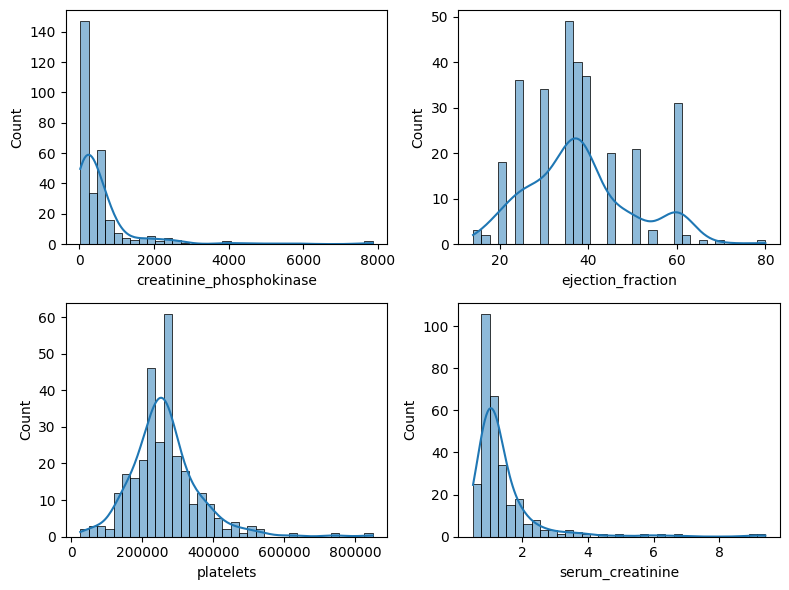

In [12]:
# Vamos plotar as distribuições de algumas variáveis que aparentam ter outliers
fig, axes = plt.subplots(2, 2, figsize=(8, 6)) 

sns.histplot(data=df, x='creatinine_phosphokinase', bins=35, kde=True, ax=axes[0, 0])
sns.histplot(data=df, x='ejection_fraction', bins=35, kde=True, ax=axes[0, 1])
sns.histplot(data=df, x='platelets', bins=35, kde=True, ax=axes[1, 0])
sns.histplot(data=df, x='serum_creatinine', bins=35, kde=True, ax=axes[1, 1])

plt.tight_layout()
plt.show()

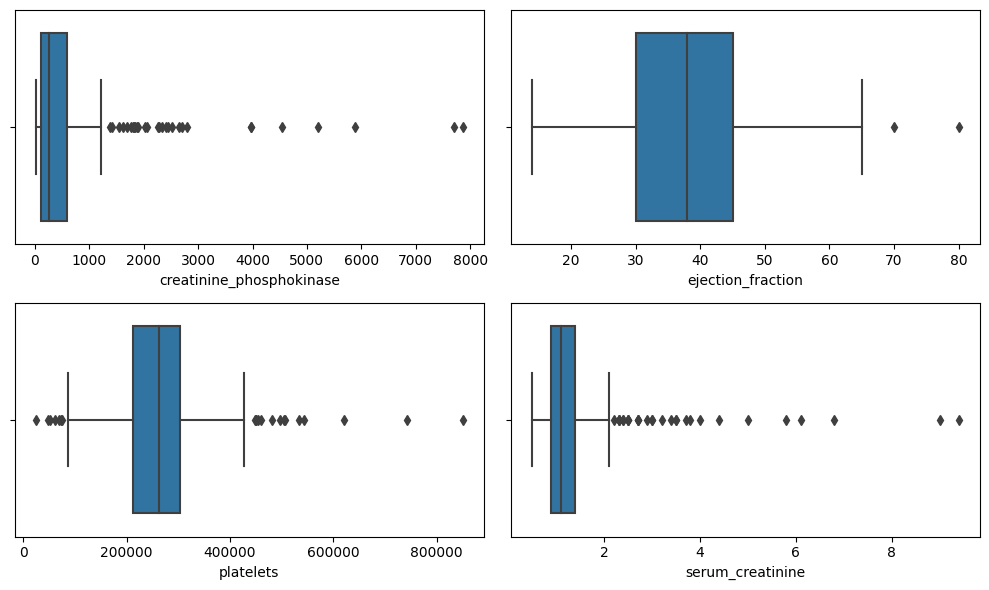

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6)) 

sns.boxplot(data=df, x='creatinine_phosphokinase', ax=axes[0, 0])
sns.boxplot(data=df, x='ejection_fraction', ax=axes[0, 1])
sns.boxplot(data=df, x='platelets', ax=axes[1, 0])
sns.boxplot(data=df, x='serum_creatinine', ax=axes[1, 1])

plt.tight_layout()
plt.show()

Correlações

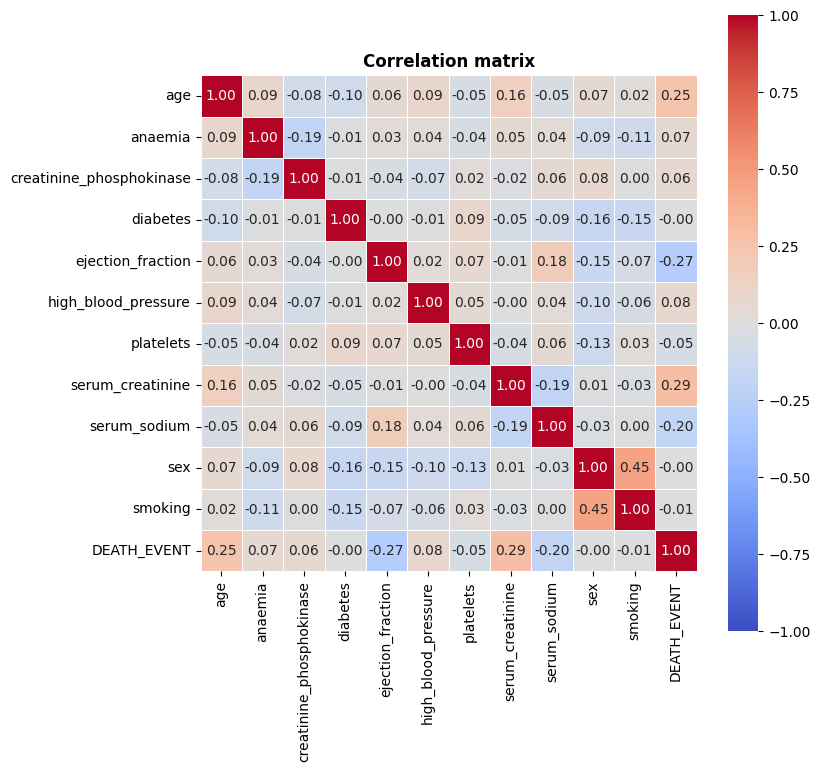

In [14]:
corr = df.corr()

plt.figure(figsize=(8,8))
sns.heatmap(corr, annot=True, fmt='.2f', square= True,
            linewidth=.5, cmap='coolwarm',vmin=-1, vmax=1)
plt.title('Correlation matrix', fontweight='bold')
plt.show()

In [15]:
def plot_target_variable_correlation(df, corr, target_variable):
    '''
        Method plots the correlation of each variable with a given target variable.
    '''
    correlation = np.array(corr[target_variable])

    # remove correlation with itself
    correlation = np.delete(correlation, np.where(correlation == 1))
    columns = np.array(df.keys())
    columns =  np.delete(columns, np.where(columns == target_variable))

    # If some column has a boolean type, it won't appear in the correlation matrix.
    # So, we have to remove it from the columns variable before plotting.
    if len(corr) < len(columns):
        columns = [x for x in columns if x in corr.columns]

    plt.figure(figsize=(15, 7))
    plt.bar(columns, correlation)
    
    # Insert the correlation value above or below the respective bar.
    for i in range(len(correlation)):
        if correlation[i] > 0:
            va="bottom"
        else:
            va="top"
        plt.text(i, correlation[i], round(correlation[i], 2), ha="center", va=va)

    title = "Correlation with '{variable}' variable".format(variable = target_variable)
    plt.title(title)
    plt.xticks(rotation = 45)
    plt.show(True)

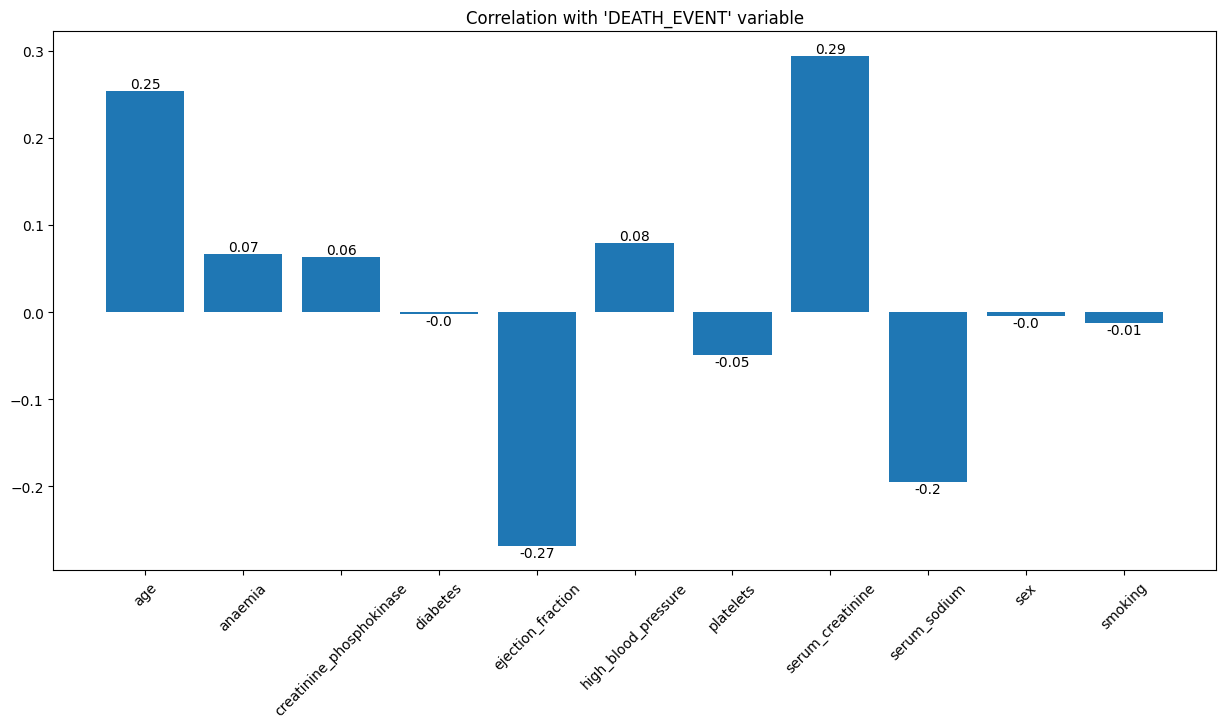

In [16]:
plot_target_variable_correlation(df, corr, 'DEATH_EVENT')

# Separação Treino-Teste

In [17]:
from sklearn.model_selection import train_test_split

X = df.drop(['DEATH_EVENT'], axis=1)
y = df['DEATH_EVENT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 24)

In [18]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(239, 11)
(60, 11)
(239,)
(60,)


## Tratando Outliers

In [19]:
# Para tratar os valores extremos, vamos usar os outliers de Tukey:
# Outlier inf se < 1º Quartil - 1.5 * Amplitude interquartil
# Outlier sup se > 3º Quartil + 1.5 * Amplitude interquartil

def Tukey_outliers(df, var, k=1.5): #K é um multiplicador, originalmente 1.5
    IQR = df[var].quantile(0.75) - df[var].quantile(0.25)
    lim_inf = df[var].quantile(0.25) - k * IQR
    lim_sup = df[var].quantile(0.75) + k * IQR
    return lim_inf, lim_sup

In [20]:
# EXEMPLO
for var in ['creatinine_phosphokinase', 'platelets', 'serum_creatinine']:
    print(f'{var}: {Tukey_outliers(X_train, var)}')

creatinine_phosphokinase: (-573.0, 1275.0)
platelets: (81250.0, 435250.0)
serum_creatinine: (1.1102230246251565e-16, 2.4)


Vamos usar tais valores como piso/teto para os outliers:

In [21]:
for var in ['creatinine_phosphokinase', 'platelets', 'serum_creatinine']:
    inf, sup = Tukey_outliers(X_train, var)
    for i in range(len(X_train[var])):
        X_train.loc[X_train[var] < inf, var], X_test.loc[X_test[var] < inf, var] = inf, inf
        X_train.loc[X_train[var] > sup, var], X_test.loc[X_test[var] > sup, var] = sup, sup

In [22]:
X_train.describe()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium
count,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000
mean,61.009766,446.979079,37.866109,258609.910586,1.270837,136.606695
std,11.890466,398.105107,11.798326,79915.173906,0.493622,4.461332
min,40.000000,30.000000,14.000000,81250.000000,0.500000,113.000000
25%,51.000000,120.000000,30.000000,214000.000000,0.900000,134.000000
50%,60.000000,270.000000,38.000000,262000.000000,1.100000,137.000000
75%,70.000000,582.000000,45.000000,302500.000000,1.500000,140.000000
max,95.000000,1275.000000,70.000000,435250.000000,2.400000,148.000000


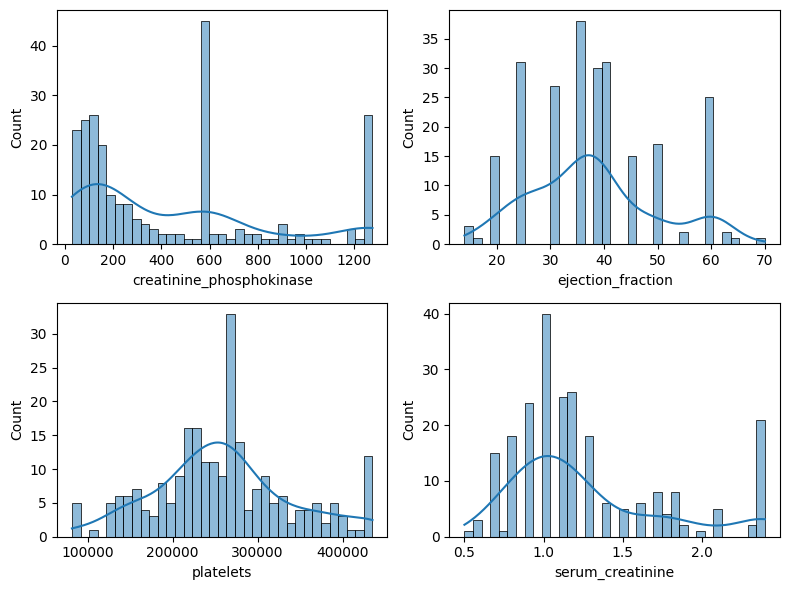

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6)) 

sns.histplot(data=X_train, x='creatinine_phosphokinase', bins=35, kde=True, ax=axes[0, 0])
sns.histplot(data=X_train, x='ejection_fraction', bins=35, kde=True, ax=axes[0, 1])
sns.histplot(data=X_train, x='platelets', bins=35, kde=True, ax=axes[1, 0])
sns.histplot(data=X_train, x='serum_creatinine', bins=35, kde=True, ax=axes[1, 1])

plt.tight_layout()
plt.show()

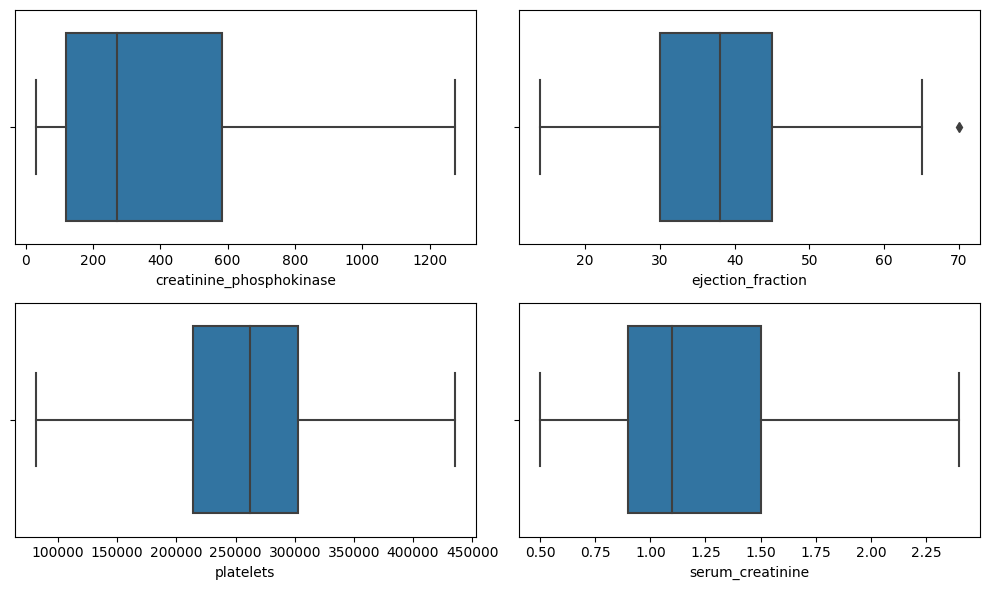

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6)) 

sns.boxplot(data=X_train, x='creatinine_phosphokinase', ax=axes[0, 0])
sns.boxplot(data=X_train, x='ejection_fraction', ax=axes[0, 1])
sns.boxplot(data=X_train, x='platelets', ax=axes[1, 0])
sns.boxplot(data=X_train, x='serum_creatinine', ax=axes[1, 1])

plt.tight_layout()
plt.show()

In [25]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train) # "calibra" a função de transformação usando dados de treino e aplica na base de treino
X_test = scaler.transform(X_test) # Aplica função *baseada no treino* para o conjunto de teste

In [26]:
pd.DataFrame(X_train).describe()

,0,1,2,3,4,5,6,7,8,9,10
count,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000
mean,0.381996,0.439331,0.334923,0.435146,0.426181,0.343096,0.501017,0.405704,0.674477,0.640167,0.297071
std,0.216190,0.497347,0.319763,0.496817,0.210684,0.475740,0.225749,0.259801,0.127467,0.480958,0.457927
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.200000,0.000000,0.072289,0.000000,0.285714,0.000000,0.375000,0.210526,0.600000,0.000000,0.000000
50%,0.363636,0.000000,0.192771,0.000000,0.428571,0.000000,0.510593,0.315789,0.685714,1.000000,0.000000
75%,0.545455,1.000000,0.443373,1.000000,0.553571,1.000000,0.625000,0.526316,0.771429,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Feito o tratamento dos dados, vamos conhecer alguns algoritmos e observar como eles performam no problema proposto: 

# 1º Modelo: KNN

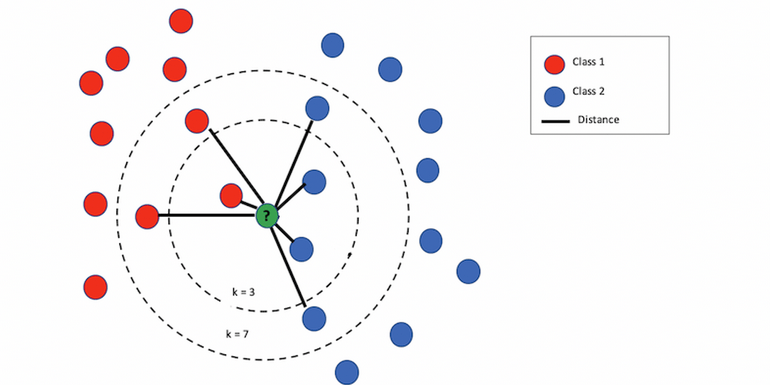

   O algoritmo K-Nearest-Neighbours é uma das alternativas mais simples dentre os modelos de classificação, a imagem acima representa o caso onde a variável resposta possui duas classes (no nosso contexto, se o paciente possui ou não insuficiência cardíaca) e duas variáveis explicativas (independentes) como sendo os eixos X e Y, desta forma, para cada nova linha observada do conjunto de teste o algoritmo calcula a distância euclidiana entre o novo ponto e todos os outros existentes no conjunto de treino, selecionam-se então os K pontos mais próximos (menor distância euclidiana calculada), de modo que a decisão de incluir o novo paciente na classe "exposto" ou "saudável" é tomada a depender de quantos pontos pertencem a cada classe dentre os K pontos selecionados.<br/><br/>
                       

<p style="text-align: center;">$d = \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}$</p>
                                
   <br/>Por exemplo: Ao calcular as distâncias, foram separados os k=7 pontos mais próximos, dos quais 5 faziam parte da classe que apresentava insuficiência cardíaca e 2 eram saudáveis, de forma que o algoritmo prevê que o novo paciente possui tal condição.<br/><br/>
   Uma outra forma de pensar é imaginar uma circunferência centrada no novo ponto, cujo raio se expande até conter K 'vizinhos', daí realizar a contagem normalmente. Se houverem 3 variáveis explicativas teríamos uma esfera, para 4> variáveis já não é possível a visualização, mas a fórmula para calcular as distâncias é a mesma:
<p style="text-align: center;">distancia entre os pontos $a$ e $b$, com $n$ vars explicativas</p>
<p style="text-align: center;">$d = \sqrt{\sum_{i=1}^{n} (b_i - a_i)^2}$</p>
    
    

#### KNN Básico

In [27]:
# KNN uma única vez:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors = 7) # Escolhe-se um N
model.fit(X_train,y_train) # efetua-se o treinamento

# Acurácia
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test) # Modelo treinado avalia conjunto de teste
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia:", accuracy)

Acurácia: 0.7166666666666667


#### KNN com Cross-Validation

In [28]:
# Cross validation, KNN 'cv' vezes:
from sklearn.model_selection import cross_val_score

modelo_cv = KNeighborsClassifier(n_neighbors=7) # escolhe o modelo
cv_scores = cross_val_score(modelo_cv, X_train, y_train, scoring='accuracy', cv=5) # escolhe qtd de folds (treinamentos)
print(cv_scores) # acurácia de cada treino
print('cv_scores mean: {:.4f}'.format(np.mean(cv_scores))) # média final dos scores

[0.64583333 0.625      0.66666667 0.64583333 0.72340426]
cv_scores mean: 0.6613


#### **O Melhor KNN:** tunando parâmetros com GRIDSEARCH

GridSearch é usado para achar o melhor número de vizinhos (K), cross-validation incluso

In [29]:
from sklearn.model_selection import GridSearchCV
model = KNeighborsClassifier()                 # Seleciona modelo KNN
num_viz = {'n_neighbors': np.arange(1, 25)}     # Treinar com N = 1 ~ 25 vizinhos (escolha)
knn_gscv = GridSearchCV(model, num_viz, cv=5)  # Cross-validation
resultado = knn_gscv.fit(X_train, y_train)      # Guarda previsão feita com melhor N

print(f"O melhor score obtido foi {knn_gscv.best_score_} usando {knn_gscv.best_params_}")

O melhor score obtido foi 0.7031914893617021 usando {'n_neighbors': 2}


Vamos aplicar os melhores parâmetros e prever para os dados de teste:

In [30]:
model = KNeighborsClassifier(n_neighbors = 2) # Melhor N
model.fit(X_train,y_train)

y_pred = model.predict(X_test) # Modelo treinado avalia conjunto de teste
accuracy = accuracy_score(y_test, y_pred)
print('Acurácia: {:.4f}'.format(accuracy))

Acurácia: 0.7167


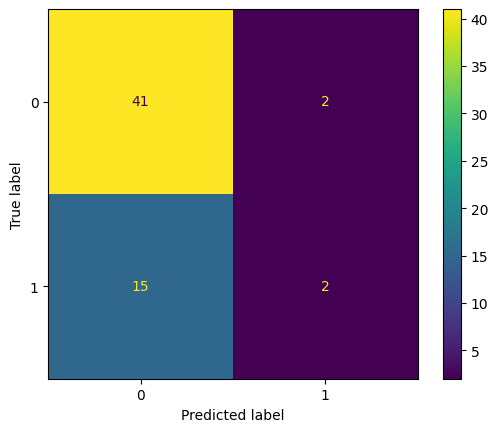

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = model.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

disp.plot()
plt.show()

In [32]:
from sklearn.metrics import classification_report

classes = ['Saudável','Exposto']
print(classification_report(y_test, predictions, target_names=classes))

              precision    recall  f1-score   support

    Saudável       0.73      0.95      0.83        43
     Exposto       0.50      0.12      0.19        17

    accuracy                           0.72        60
   macro avg       0.62      0.54      0.51        60
weighted avg       0.67      0.72      0.65        60



In [33]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, predictions)

0.5355677154582763

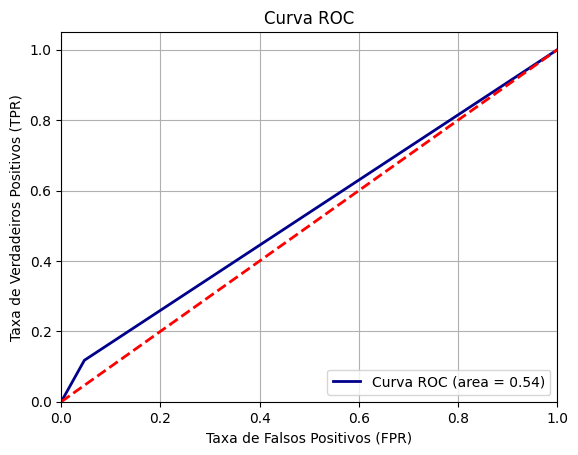

In [34]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkblue', lw=2, label='Curva ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Documentação: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

# 2º Modelo: Random Forest

Primeiro, uma única árvore de decisão:

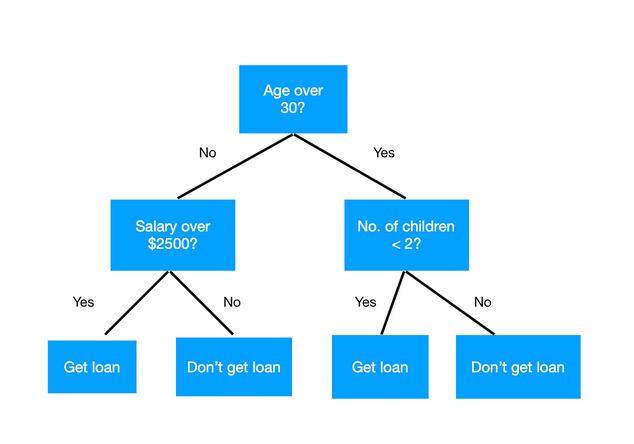

In [35]:
from sklearn.tree import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier(random_state=24)
dt_classifier.fit(X_train, y_train)
y_pred = dt_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia: {accuracy:.4f}")

Acurácia: 0.6833


In [36]:
!pip install pydotplus

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.7/278.7 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24552 sha256=9890d6ba39339216821e13379ff427ea9fb8b400b4d97bac454c8dfc418f3064
  Stored in directory: /root/.cache/pip/wheels/69/b2/67/08f0eef649af92df772c09f451558298e07fab1bc7cdf33db0
Successfully built pydotplus


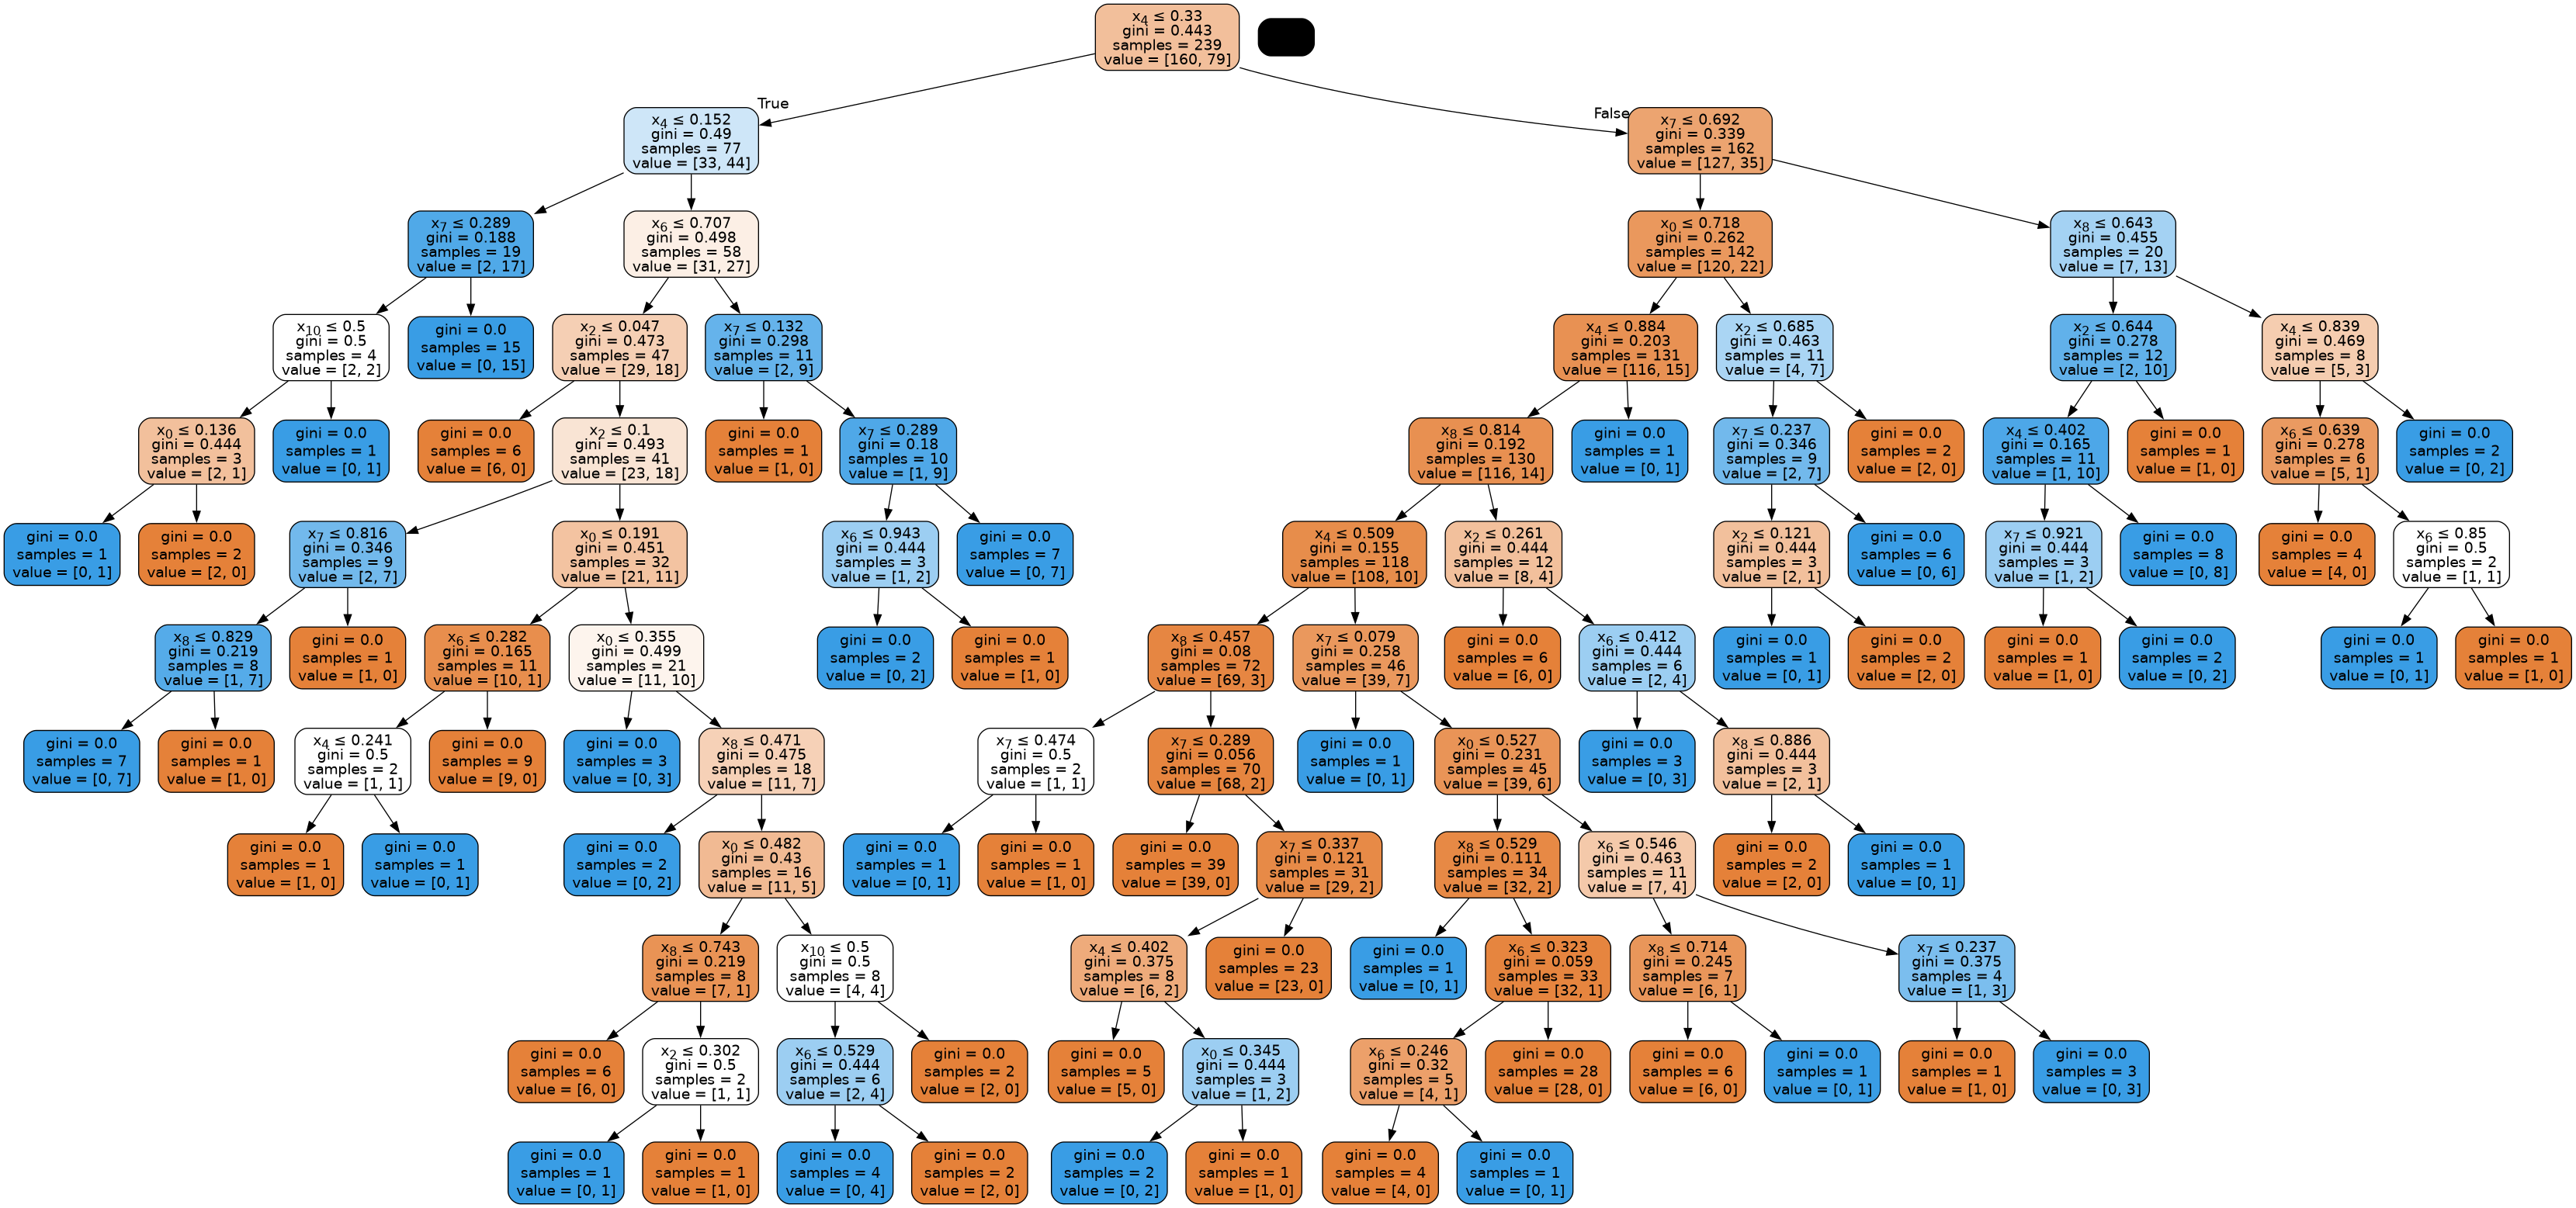

In [37]:
from sklearn.tree import export_graphviz
import graphviz
from IPython.display import Image
import pydotplus

dot_data = export_graphviz(dt_classifier, out_file=None, filled=True, 
                           rounded=True,  special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

* Prós: Performa bem, tem boa interpretabilidade
* Contras: Sensível aos dados de treino, overfita com facilidade

Alternativa: Construir várias árvores, cada uma com uma amostra aleatória dos dados de treino (bootstrapping) e usando diferentes variáveis para criar as regras de divisão em cada ramo; para cada novo dado, percorrem-se as árvores e contabiliza-se em quantas delas o novo ponto foi avaliado como sendo da classe 1 e quantos da classe 2, por fim decide-se pela maioria.
<br/><br/>
Este método se chama Random Forest e reduz os problemas relacionados a alta variabilidade sobre o conjunto de treino

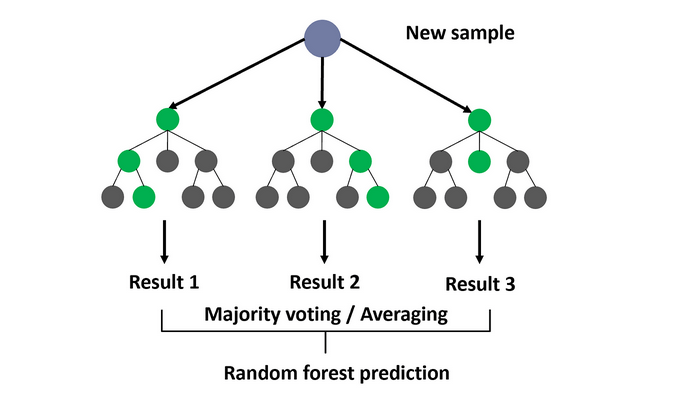

#### Random Forest Básico

In [38]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=24)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.7666666666666667

#### Random Forest tunado

Vamos rodar o GridSearch para encontrar os melhores parâmetros para o RandomForest, para isto, basta fornecer números/intervalos para o computador testar todas as combinações:

In [39]:
# Cuidado, pode demorar para rodar
param_grid = { 
    'n_estimators': [200, 500], # número de árvores na floresta
    'max_features': ['sqrt', 'log2'], # número de features a se considerar para cada divisão
    'max_depth' : [7,8,9,10], # profundidade máxima da árvore
}
grid = GridSearchCV(estimator=RandomForestClassifier(random_state=24), param_grid=param_grid, cv= 5, verbose=1)
grid_search_RF = grid.fit(X_train, y_train)

print('\n Melhores parâmetros: ',grid_search_RF.best_params_)
print('\nScore: ',grid_search_RF.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits

 Melhores parâmetros:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 200}

Score:  0.7322695035460993


Note que ele está usando parte do conjunto de treino como validação, vamos realizar a predição no conjunto de teste:

In [40]:
model = RandomForestClassifier(n_estimators=200, max_depth=7, max_features='sqrt', random_state=24)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.7833333333333333

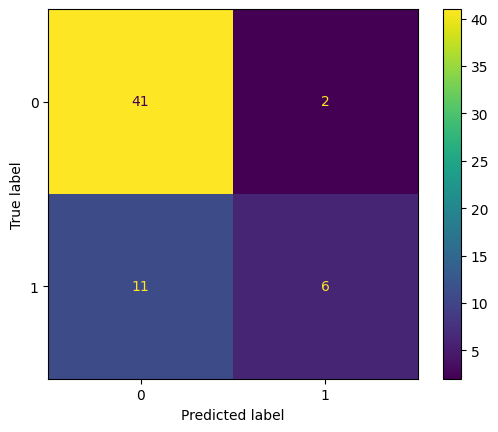

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = model.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

disp.plot()
plt.show()

In [42]:
from sklearn.metrics import classification_report

classes = ['Saudável','Exposto']
print(classification_report(y_test, predictions, target_names=classes))

              precision    recall  f1-score   support

    Saudável       0.79      0.95      0.86        43
     Exposto       0.75      0.35      0.48        17

    accuracy                           0.78        60
   macro avg       0.77      0.65      0.67        60
weighted avg       0.78      0.78      0.75        60



In [43]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, predictions)

0.6532147742818059

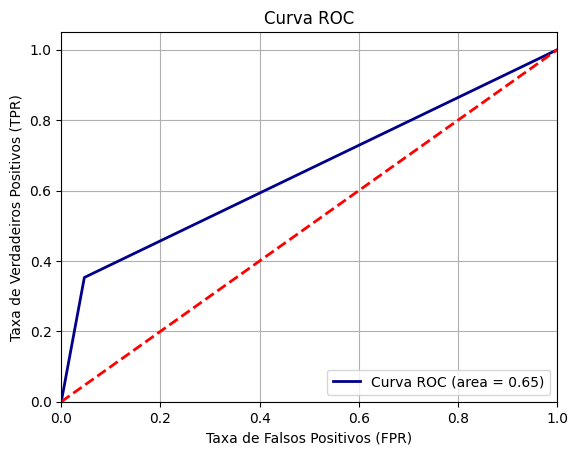

In [44]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkblue', lw=2, label='Curva ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Documentação: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

# 3º Modelo: SVM

Suport Vector Machine é um algoritmo no qual se deseja obter uma reta/ hiperplano que segregue os dados de treino em duas regiões, o melhor hiperplano (maior distância dos grupos, margem de maior amplitude) é obtido internamente pela solução de um problema de otimização convexa. <br/><br/> Novos pontos são classificados simplesmente com base na região em que suas coordenadas o posicionarem.

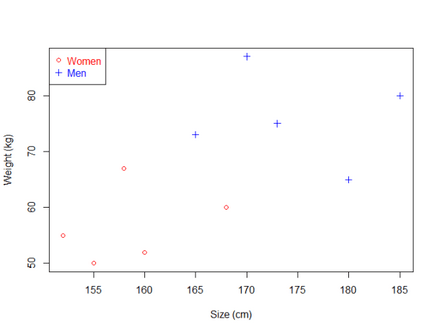
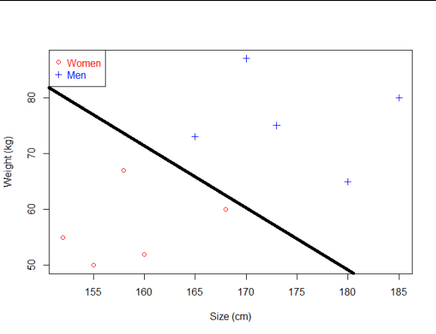
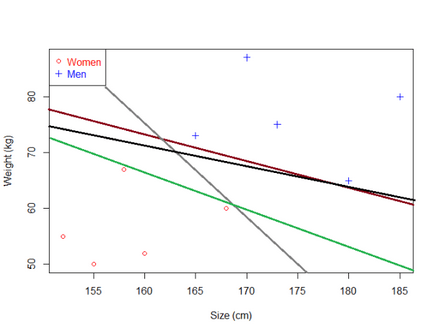
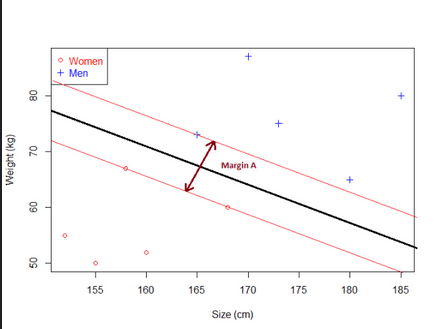
<br/>
https://www2.decom.ufop.br/imobilis/svm-entendendo-sua-matematica-parte-1-a-margem/#:~:text=O%20SVM%20%C3%A9%20uma%20t%C3%A9cnica%20de%20classifica%C3%A7%C3%A3o%20baseada%20em%20aprendizado,cada%20classe%20estejam%20previamente%20classificadas


Kernel Trick<br/>
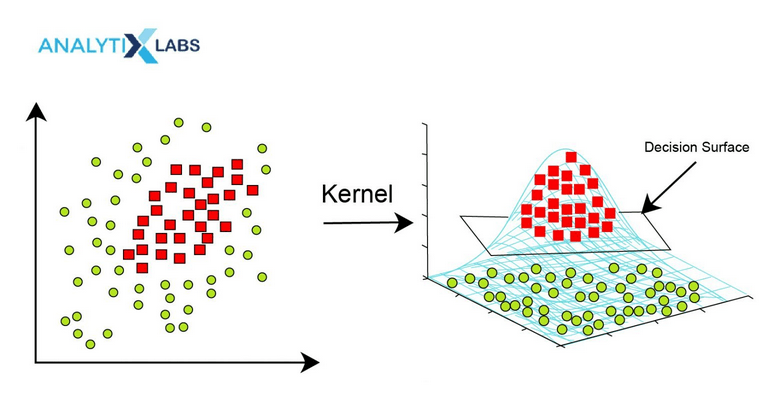

#### SVM Básico

In [45]:
from sklearn.svm import SVC
model = SVC()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.7666666666666667

#### SVM tunado

In [46]:
param_grid = {
    'C': [1,10,50], # paramêtro de regularização
    'gamma': [1, 0.1, 0.005, 0.00001, 0.0000001], # coeficiente do kernel
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
} 
grid = GridSearchCV(SVC(), param_grid, cv=5, verbose = 1)
grid_search_svm=grid.fit(X_train, y_train)

print('\n Melhores parâmetros: ',grid_search_svm.best_params_)
print('\nScore: ',grid_search_svm.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits

 Melhores parâmetros:  {'C': 10, 'gamma': 1, 'kernel': 'linear'}

Score:  0.7321808510638298


In [47]:
model = SVC(C=10, kernel='linear', gamma=1)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8333333333333334

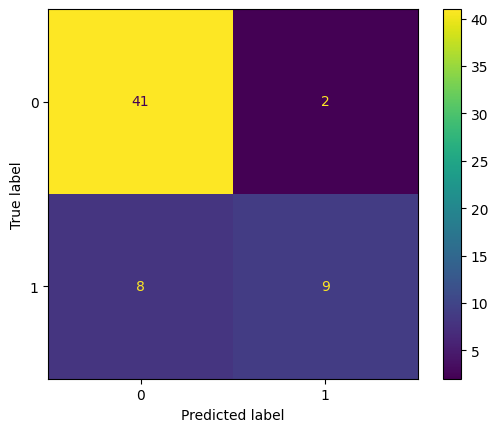

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = model.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

disp.plot()
plt.show()

In [49]:
from sklearn.metrics import classification_report

classes = ['Saudável','Exposto']
print(classification_report(y_test, predictions, target_names=classes))

              precision    recall  f1-score   support

    Saudável       0.84      0.95      0.89        43
     Exposto       0.82      0.53      0.64        17

    accuracy                           0.83        60
   macro avg       0.83      0.74      0.77        60
weighted avg       0.83      0.83      0.82        60



In [50]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, predictions)

0.7414500683994528

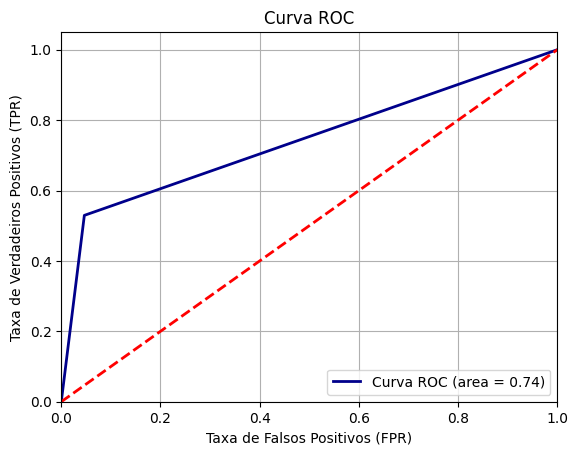

In [51]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkblue', lw=2, label='Curva ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Documentação: https://scikit-learn.org/stable/modules/svm.html

# 4º Modelo: Regressão logística

A regressão logística se baseia na curva da função sigmoide, a qual recebe valores reais e os mapeia no intervalo $[0,1]$, isto é:<br/><br/> $\large f(X): \mathbb{R} \rightarrow [0,1]$ <br/><br/> O eixo $y$ representa a probabilidade do ponto pertencer a classe '$1$' (a função transforma os log-odds da combinação linear em uma probabilidade). A priori, todos os pontos com $p \geq 0.50$ <br/> serão considerados como sendo da classe '$1$' e aqueles com $p < 0.50$ da classe '$0$'.

Considere a função Sigmoide:
<br/><br/>
$\large z = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \ldots + \beta_n X_n$
<br/><br/>

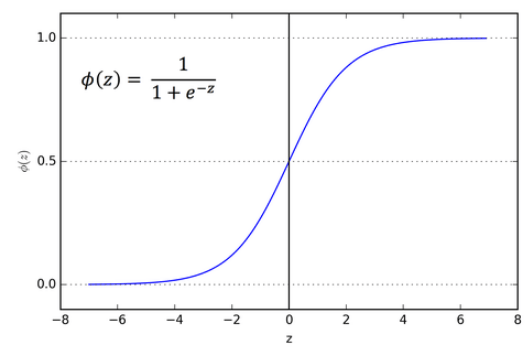

#### Regressão Logística Básica

In [52]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=24)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8333333333333334

Regressão Logística tunada

In [53]:
param_grid = {
    'penalty': ['l1','l2'], # tipo de penalidade (lasso ou Ridge)
    'C': [100, 10, 1, 0.1, 0.01, 0.0001] # paramêtro de regularização
} 

grid_search_logit = GridSearchCV(LogisticRegression(random_state=24), param_grid, scoring='accuracy', cv=5, verbose=1)
grid_search_logit.fit(X_train, y_train)

print('\n Melhores parâmetros: ',grid_search_logit.best_params_)
print('\nScore: ',grid_search_logit.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits

 Melhores parâmetros:  {'C': 10, 'penalty': 'l2'}

Score:  0.7155141843971631


#### Ajustando o limiar
Se os dados forem viesados para algum lado, ou seja, se as probabilidades previstas foram distantes do 50|50, é interessante considerar a alteração do limiar (treshold) para um mais adequado, para isso, vamos testar alguns limiares e comparar suas curvas ROC:

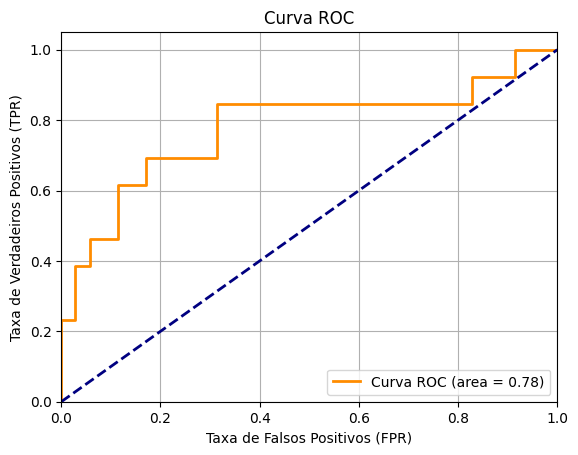

Threshold ótimo para equilíbrio TPR-FPR: 0.34264064389394405


In [54]:
# O código a seguir obtém o treshold ideal com base apenas nos dados de treino
from sklearn.metrics import precision_recall_curve, roc_curve, auc

X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

model = LogisticRegression(random_state=24)
model.fit(X_train_new, y_train_new)

y_scores_val = model.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_scores_val)
roc_auc = auc(fpr, tpr)

# Curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Threshold ótimo para equilíbrio TPR-FPR: {optimal_threshold}")

modelo tunado e limiar ajustado:

In [55]:
# Fit ideal
model = LogisticRegression(penalty='l2', C=10, random_state=24)
model.fit(X_train, y_train)
model.score(X_test, y_test)
####################################################################
# Treshold
y_scores = grid_search_logit.predict_proba(X_test)[:, 1]
threshold = optimal_threshold  # passar o treshold ideal obtido
y_pred = (y_scores >= threshold).astype(int)

# Desempenho sob novo threshold:
accuracy = grid_search_logit.score(X_test, y_test)
print(f"Acurácia com threshold ajustado: {accuracy:.4f}")

Acurácia com threshold ajustado: 0.8167


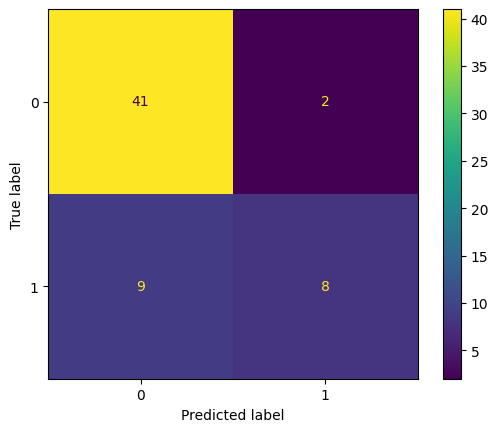

In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = model.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

disp.plot()
plt.show()

In [57]:
from sklearn.metrics import classification_report

classes = ['Saudável','Exposto']
print(classification_report(y_test, predictions, target_names=classes))

              precision    recall  f1-score   support

    Saudável       0.82      0.95      0.88        43
     Exposto       0.80      0.47      0.59        17

    accuracy                           0.82        60
   macro avg       0.81      0.71      0.74        60
weighted avg       0.81      0.82      0.80        60



In [58]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, predictions)

0.7120383036935706

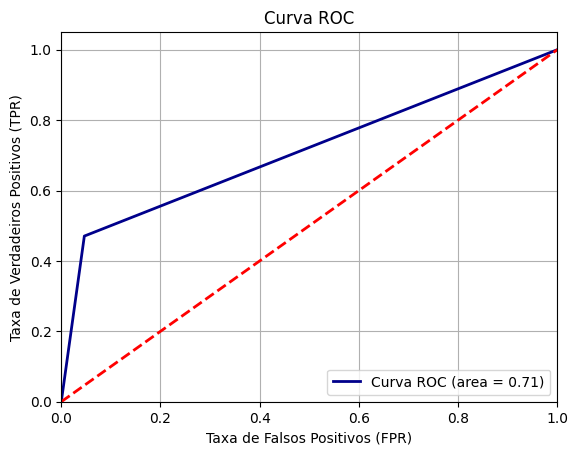

In [59]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkblue', lw=2, label='Curva ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Documentação: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Referências: <br/>
1. Notebook antigo: https://www.kaggle.com/code/richardsousaantunes/projeto-titanic-espacial-pt-2
2. Tutorial Regressão Logística: https://www.kaggle.com/code/prashant111/logistic-regression-classifier-tutorial
3. Página da wikipedia sobre Reg. logist: https://en.wikipedia.org/wiki/Logistic_regression
4. Matriz de confusão: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_estimator
5. Gráfico ROC simples: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html#sklearn.metrics.RocCurveDisplay.from_predictions
6. Métricas em geral: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html